In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf  
import pathlib
import math
import os
import re
import cv2
import sklearn
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

<h3>Configure Tensorflow</h3>

In [2]:
config = tf.compat.v1.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
config.log_device_placement = True  # to log device placement (on which device the operation ran)  
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.compat.v1.Session(config=config)  
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras  


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:08:00.0, compute capability: 7.5



<h3> Load dataset </h3>

In [3]:
dataset_path = './histology_slides/'
dataset_path = pathlib.Path(dataset_path)

# width and height of images
image_size = 224

images = []
labels = [] # 0: benign, 1: malignant

num_malign = 0
total = 0

# search every file in the directory
for path in dataset_path.rglob("*"):
    filename, file_extension = os.path.splitext(path)
    
    # find images
    if file_extension == '.png':
        #filename format:
        #<BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>_<YEAR>-<SLIDE_ID>-<MAGNIFICATION>-<SEQ>
        meta = re.split('_|-', os.path.basename(filename)) # metadata
        
        # get label
        if meta[1] == 'M':
            labels.append(1)
            num_malign += 1
        else:
            labels.append(0)
        # load image
        img = np.asarray(Image.open(path).convert("RGB"))
        img = cv2.resize(img, (image_size, image_size))
        images.append(img)
        
        total += 1
        print('%d images loaded\r' % (total), end="")
        
print('%d images loaded' % (total))
print('malignant percentage: %d%%' % (num_malign / len(labels) * 100))

7909 images loaded
malignant percentage: 68%


<h3>Shuffle data and split test set</h3>

In [4]:
test_set_percentage = 20

#shuffle images and labels in the same order
images, labels = sklearn.utils.shuffle(images, labels)

#num samples in test set
test_size = math.floor(total * test_set_percentage / 100)

#use the last n samples of the list for testing
images_test = images[total - test_size : total]
#trim off the last n samples of the list from the main training set
images = images[0 : total - test_size]

#same as above
labels_test = labels[total - test_size: total]
labels = labels[0 : total - test_size]

images = np.array(images)
labels = np.array(labels)
images_test = np.array(images_test)
labels_test = np.array(labels_test)

print(str(len(images)) + ' samples in training set')
print(str(len(images_test)) + ' samples in testing set')

6328 samples in training set
1581 samples in testing set


<h3>Create Model</h3>

In [5]:
# pre-trained network trained on a variety of images
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

model = Sequential()
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

<h3>Train Model</h3>

In [12]:
history = model.fit(images, labels, epochs=1, batch_size = 16, validation_data = (images_test, labels_test))

Train on 6328 samples, validate on 1581 samples
6328/6328 [==============================] - 81s 13ms/sample - loss: 0.0217 - accuracy: 0.9949 - val_loss: 0.0833 - val_accuracy: 0.9728


<h3>Some samples and predictions</h3>

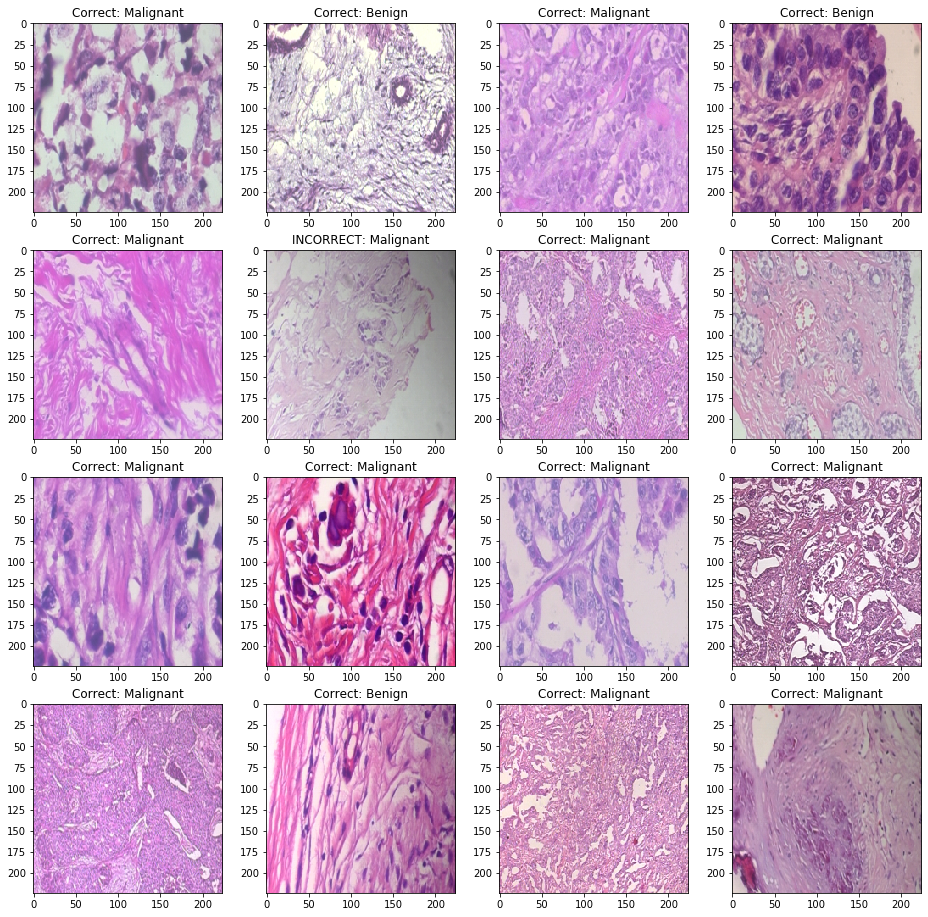

In [74]:
samples = 16

#random index in the test set
index = random.randint(0, test_size - samples)
#make predictions for all samples starting at that index
predictions = model.predict(images_test[index:index + samples])

fig=plt.figure(figsize=(16, 16))

for i in range(0, samples):
    ax = fig.add_subplot(samples // 4, 4, i + 1)
    title = ''
    
    if round(predictions[i][0]) == labels_test[i + index]:
        title += 'Correct: '
    else:
        title += 'INCORRECT: '
    
    if labels_test[i + index] == 0:
        title += 'Benign'
    else:
        title += 'Malignant'
    
    ax.title.set_text(title)
    plt.imshow(images_test[i + index], interpolation='nearest')
    
plt.show()